{'sadness': 0.003144717, 'disgust': 4.735815e-06, 'fear': 1.08231681e-07, 'neutral': 0.996283948, 'anger': 6.79822324e-06, 'happiness': 2.98663181e-05, 'contempt': 0.0005088959, 'surprise': 2.091226e-05}
[10, 'neutral']


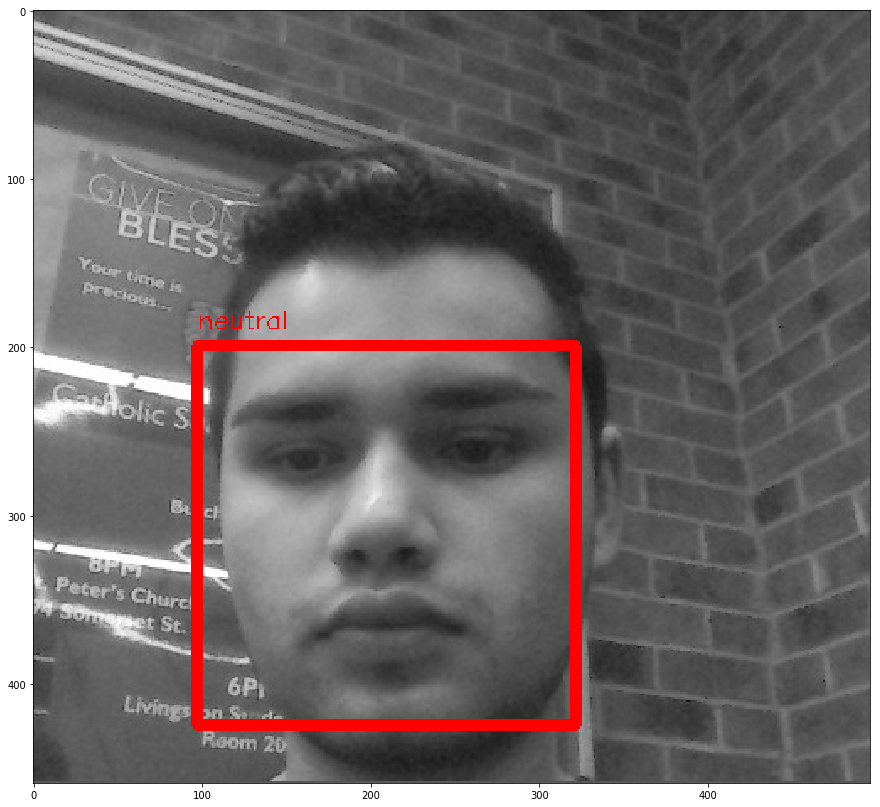

In [4]:

# coding: utf-8

# In[131]:

import time
import requests
import cv2
import operator
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 


# In[133]:

_url = 'https://westus.api.cognitive.microsoft.com/emotion/v1.0/recognize'
_key= 'a9676e1d0c594525954aab7dc77e75d0'


# In[148]:

def processRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result


# In[168]:

def read_and_classifyImage():
   pathToImage = 'Tas.jpg'
   with open( pathToImage, 'rb' ) as f:
       data = f.read()

   headers = dict()
   headers['Ocp-Apim-Subscription-Key'] = _key
   headers['Content-Type'] = 'application/octet-stream'

   json = None
   params = None

   result = processRequest( json, data, headers, params )

   #this part of the code grabs the maximum value emotion and emotion-rank
   x=result[0]['scores'] #get the list of possible emotion and their rank
   print(result[0]['scores'])
   keys=[] #dummy dictionary
   values=[]
   for key,value in x.items():
       keys.append(key)
       values.append(value)
   max_value=max(values)
   max_values=list((math.ceil((max(values)*10)),keys[values.index(max_value)]))
   print(max_values)
   if result is not None:
    # Load the original image from disk
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    
    ax.imshow( img )

def renderResultOnImage(result,img):
    
    """Display the obtained results onto the input image"""
    
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 5 )


    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currEmotion = max(currFace['scores'].items(), key=operator.itemgetter(1))[0]


        textToWrite = "%s" % ( currEmotion )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1 )

read_and_classifyImage()